# Lost options commitment: how short-term policies affect long-term scope of action

In this notebook we show how the main computations on the article [Lost options commitment: how short-term policies affect long-term scope of action](https://academic.oup.com/oocc/advance-article/doi/10.1093/oxfclm/kgae004/7606781?utm_source=advanceaccess&utm_campaign=oocc&utm_medium=email)

For this aim:
- we import the code of the [SURFER model](https://gmd.copernicus.org/articles/15/8059/2022/) together with an extra function surfer_commit! which allows to force the system with more sophisticated emissions and injections. This is required for the forcing the model with the emissions and injections that correspond to the longterm CDR and SRM options
- we import the co2 emissions corresponding to SSP scenarios. We use the same emission data that was used on the [SURFER](https://gmd.copernicus.org/articles/15/8059/2022/) paper
- we define the different longterm options 
- we do the commitment assessment and reproduce top plot of Fig. 2 in the [article](https://academic.oup.com/oocc/advance-article/doi/10.1093/oxfclm/kgae004/7606781?utm_source=advanceaccess&utm_campaign=oocc&utm_medium=email)
- we define the matrix graphic representation of the results

All sensitivity analysis present in the [article](https://academic.oup.com/oocc/advance-article/doi/10.1093/oxfclm/kgae004/7606781?utm_source=advanceaccess&utm_campaign=oocc&utm_medium=email) can be reproduced with the provided code.

## Importing required packages, SURFER model and SSP scenarios

In [1]:
using DifferentialEquations
using Plots
using DelimitedFiles
using Interpolations
using Roots
using LaTeXStrings
using IterTools

In [2]:
include("SURFER-commit.jl")
include("load_ssp_scenarios.jl")

## Define states and longterm options

### longterm options

We consider that the future possible options (these options are state dependent) are a combination of the following options:

- **Decarbonisation**: three decarbonisation rates $$0.08Pg/yr^2, 0.25Pg/yr^2, 0.75Pg/yr^2$$.

- **Aerosol injections**: two max intensities (20MtS/yr,40MtS/yr), two durations of aerosol injections *short* and *long*. We define *short* as the time it takes to achieve full decarbonisation and *long* to the whole commitment assessment timescale. SRM options are applied smartly such that just the necessary amount of aerosols is injected to return to pre-industrial temperatures. 

- **Carbon Dioxide Removal**: two rates (−1PgC/yr, −2PgC/yr). CDR will start at the beginning affecing the net emissions. It will go on until all anthropogenic CO2 has been removed. There is also the option of no CDR.

Total future options considered = `[(3 decarbonisations) * (2(SO2 short) + 1(no SO2) + 2(SO2 long)) * 3(cdr)] `

That gives a total of 45 scenarios: 
1. Decarbonisation in at rate 0.08 PgC/yr$^2$ and no aerosol injections
2. Decarbonisation in at rate 0.08 PgC/yr$^2$ and aerosol inections at rate 20MtS/yr during decarbonisation duration
3. ...


**Total options considered is 45**

### States

We create a structure that we call state. It contains the information:
- year
- Climate state at the year: these are all the components of the SURFER model
- Emission and Injection rates at the year

In [3]:
mutable struct Option 
    dec::Float64 # dec rate.
    SO2rate::Float64 # aerosol injection rate in MtS/yr
    SO2duration::String # "short" or "long"
    cdr::Float64 # carbon dioxide removal rate in GtC/yr
end

In [4]:
#-------------------------------
# Future possible options considered
#-------------------------------
decOpts = [-0.08,-0.25,-0.75] # dec rate in PgC/yr^2
#-------------------------------
srmOpts = [[0,"long"]] # [rate,duration]
for rate in [20,40] # injection rate in MtS/yr
    for duration in ["short","long"] 
        push!(srmOpts,[rate,duration])
    end
end
#-------------------------------
cdrOpts = [0,-1,-2]; # cdr rate in PgC/yr
#-------------------------------
FutOptions = [] # [option, option,.... ]
for dec in decOpts
    for srm in srmOpts
        srm_rate = srm[1]
        srm_duration = srm[2]
        for cdr in cdrOpts
             push!(FutOptions,Option(dec,srm_rate,srm_duration,cdr))
        end
    end
end

In [5]:
mutable struct State 
    t::Float64
    M_A::Float64
    M_U::Float64
    M_D::Float64
    M_L::Float64
    δT_U::Float64
    δT_D::Float64
    VG::Float64
    VA::Float64
    S::Float64 # Glacier's SLR since PI
    CO2rate::Float64
    SO2rate::Float64
end

In [6]:
# We will allow CDR to extract carbon untill close to pre industrial levels are reached.
# Carbon Dioxide Removal starts since the beginning
function make_emissions_injections(state::State, option::Option;extra_srm_duration = 0)
    # option data
    dec_rate = option.dec # decarbonisation rate in PgC/yr^2
    SO2_rate = option.SO2rate # TgS/yr
    SO2_duration = option.SO2duration
    cdr_rate = option.cdr
    # some state data
    M_A_0 = state.M_A
    M_U_0 = state.M_U
    M_D_0 = state.M_D
    M_L_0 = state.M_L
    CO2rate_0 = state.CO2rate
    SO2rate_0 = state.SO2rate
    t_0 = state.t
    
    # compute decarbonisation duration given initial CO2 emission rate
    if CO2rate_0 > 0
        dec_duration = abs(CO2rate_0/dec_rate)
    else
        dec_duration = 0
    end
    
    # total excess carbon w.r.t. pre industrial at the end of decarbonisation
    excess = (M_A_0 + M_U_0 + M_D_0 + M_L_0) + (CO2rate_0*dec_duration/2 + cdr_rate*dec_duration) - (M_A_PI + M_U_PI + M_D_PI + M_L_PI)
    
    # simple estimation of cdr duration (time after decarbonisation) for removing all excess carbon
    if cdr_rate < 0
        cdr_duration = -excess/cdr_rate
    else
        cdr_duration = 0.0
    end
    
    # fixing SO2_duration
    if SO2_duration == "short"
        SO2_duration = dec_duration + extra_srm_duration
    elseif SO2_duration == "long"
        SO2_duration = 40000.0 #effectively forever
    end
    
    # define injections (temperatures and M_A dependent, takes into account heat flow into deep ocean)
    function injections(t,M_A,δT_U,δT_D)#Injections(t,M_A,δT_U,δT_D)
        δTgoal = 0.0 # injections used to limit warming to δTgoal
        if t_0 <= t <= (t_0+SO2_duration)
            if δT_U > δTgoal #&& F_CO2(M_A)/β > δTgoal              
                SO2 = SO2_needed_withD(δTgoal,M_A,δT_D)
                return min(SO2_rate,SO2)
            else
                return 0
            end
        elseif t > (t_0+SO2_duration)
            return 0
        else 
            return SO2rate_0
        end
    end
        
    # define emissions
    function emissions(t,M_A,M_U,M_L)
        if t <= t_0
            return CO2rate_0
        elseif t_0 < t <= (t_0 + dec_duration)
            return -((CO2rate_0)/dec_duration)*(t - t_0) + (CO2rate_0+cdr_rate)
        elseif (t_0 + dec_duration) < t <= (t_0 + dec_duration + 10*cdr_duration) 
            if M_A > M_A_PI
                return cdr_rate
            else
                return CDR_needed(M_A,M_U,M_L)
            end
        else
            return 0
        end
        
        
    end
        
    return [ emissions, injections]

end

make_emissions_injections (generic function with 1 method)

In [7]:
function make_State(t,sol,co2,so2)
    if length(sol) != 9
        return "Error"
    else
        return State(t,sol[1],sol[2],sol[3],sol[4],sol[5],sol[6],sol[7],sol[8],sol[9],co2,so2)
    end
end

make_State (generic function with 1 method)

## Generate initial conditions for commitment assessment

Here we generate the initial conditions of the commitment assessment, which are highlighted as gray markers in Fig. A2 of the paper.

To do that we start from initial pre industrial conditions and force the system along SSP1-2.6, SSP2-4.5, SSP3-7.0 and SSP5-8.5.

We will actually store the full evolution so that if we want we can choose other dates for the commitment assessment than [2020, 2030, ..., 2100].

In [8]:
sol_list_ssp = []
for i in 1:length(ssp_itp)
    tspan = (1765.0,2300.0) # time interval
    u₀ = [M_A_PI, M_U_PI, M_D_PI, M_L_PI,0.0, 0.0, 1.0, 1.0, 0.0] # initial SURFER state vector
    sources = [ssp_itp[i], t -> 0.0] # [co2rate, so2rate]
    prob = ODEProblem(surfer!,u₀,tspan,sources)
    @time sol = solve(prob,Rosenbrock23(),reltol=1e-3,abstol=1e-12)
    push!(sol_list_ssp,sol)
end

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase ~/.julia/packages/SciMLBase/2HZ5m/src/performance_warnings.jl:32


  2.814901 seconds (4.66 M allocations: 287.748 MiB, 4.75% gc time, 99.33% compilation time)
  0.006918 seconds (209.01 k allocations: 4.986 MiB)
  0.007740 seconds (216.50 k allocations: 5.168 MiB)
  0.008840 seconds (224.43 k allocations: 5.358 MiB)


## Commitment assessment

As in the paper the focus is on sea level rise.

We define a function that checks the maximum sea level rise on the commitment horizon along a single option.

We define a function called commitment that takes a state and a SLR target and returns a percetage of lost options.

In [9]:
function check_one_option_SLR(state0,option;horizon = 2000)
    # sources for initial state and option
    sources = make_emissions_injections(state0,option)# [co2rate, so2rate]
   
    # initial state vector for ODEProblem, timespan
    u₀ = [state0.M_A, state0.M_U, state0.M_D,state0.M_L, state0.δT_U, state0.δT_D, state0.VG, state0.VA, state0.S] # initial state vector
    t0 = state0.t
    tspan = (t0,t0+horizon) # time interval

    # solving problem
    prob = ODEProblem(surfer_commit!,u₀,tspan,sources)
    sol = solve(prob,Rosenbrock23(),reltol=1e-3,abstol=1e-12)
    
    # extract maxSLR
    M_A, M_U, M_D, M_L, δT_U, δT_D, VG, VA, S = [sol[i,:] for i in 1:9]
    time = sol.t
    maxSLR = maximum(SLRtotal.(δT_U,δT_D,VG,VA,S) )
  
    return maxSLR
    
end

check_one_option_SLR (generic function with 1 method)

In [10]:
function check_one_state_SLR(state0;horizon=2000)
    aux(Option) = check_one_option_SLR(state0,Option;horizon=horizon)
    maxSLRvals = aux.(FutOptions)
    return maxSLRvals 
end

check_one_state_SLR (generic function with 1 method)

Now we do the commitment assessment for all states every 10 years along the considered SSP scenarios.

We will store all max SLR values for all options and all states assessed. That way we can keep track of which individual options have been lost

`slr_ssp_yrs` is a nested list. Biggest level corresponds to SSP scenario. Second level corresponds to the year of the initial state, and third level corresponds to the different longterm options.

In [11]:
slr_ssp_yrs = []
yrs_assessment = [yr0 for yr0 in 2020:10:2100]
@time for iscen in 1:4
    slr = []
    for yr0 in yrs_assessment
        # initial state
        u₀ = sol_list_ssp[iscen](yr0)
        state0 = make_State(yr0,u₀,ssp_itp[iscen](yr0),0.0)
        SLRs = check_one_state_SLR(state0; horizon = 2000)
        push!(slr, SLRs)
    end
    push!(slr_ssp_yrs, slr)
end

 17.980083 seconds (741.17 M allocations: 16.981 GiB, 7.38% gc time, 12.38% compilation time)


### Commitment level over time

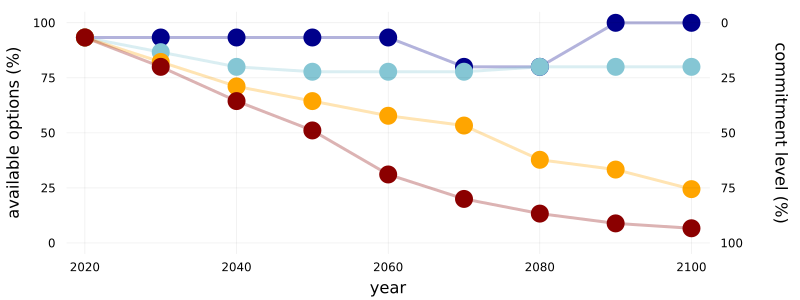

In [12]:
SLR_target = 3 # meters
safe_slr_all = []
#
for iscen in 1:4
    slr_scen = []
    for iyr in 1:length(yrs_assessment)
        push!(slr_scen,sum(slr_ssp_yrs[iscen][iyr] .<= SLR_target))
    end
    push!(safe_slr_all,slr_scen)
end
# Plotting
colors = [palette(:blues)[2],palette(:ice)[200],palette(:heat)[2],palette(:heat)[3]]
p=plot(xlabel="year", ylabel="available options (%)")
for i in 1:4
    plot!(yrs_assessment,100*(safe_slr_all[i])./length(FutOptions),label=false,color=colors[i],titlefontsize=12,
        lw=3,alpha=0.3)
    scatter!(yrs_assessment,100*( safe_slr_all[i])./length(FutOptions),label=false,color=colors[i],
        markerstrokewidth=0,markersize=10)
end
plot!(legend=:bottomleft,yrange=(-5,105),size=(800,300),yticks=([0,25,50,75,100],reverse(["100","75","50","25","0"])))
plot!(bottom_margin = 4Plots.mm, left_margin = 4Plots.mm, right_margin = 10Plots.mm,
    gridlines=true,framestyle=:grid)
#plot!(dpi=300)
p=twinx()
plot!(p,label=false,yrange=(-5,105),yticks=([0,25,50,75,100],["100","75","50","25","0"]),
    xticks=false,ylabel="commitment level (%)",grid=(:y),framestyle=:grid,yguidefontrotation=180)

### Which options are lost

Here we create a couple of functions for the graphic matrix representation of the lost options for a given state.
- `get_coord` takes an option and returns the (x,y) position of the optuib in the matrix diagram together with a fillalpha value to differentiate CDR options.
- `plot_options` takes (`options`,`year`,`color`) and does the diagram for the given `options` crossed out, with `year` in the title and in the specified `color`

In [13]:
function get_coord(option)
    so2_rate = option.SO2rate
    so2_duration = option.SO2duration
    dec = option.dec
    cdr = option.cdr
    # x coord for different SRM
    if so2_rate == FutOptions[1].SO2rate
        x = 1
        fillstyle = :none
    elseif so2_rate == FutOptions[4].SO2rate
        fillstyle = :/
        if so2_duration == "short"
            x = 2
        else
            x = 4
        end
    elseif so2_rate == FutOptions[10].SO2rate
        fillstyle = :x
        if so2_duration == "short"
            x = 3
        else
            x = 5
        end
    end
    # y coord for different dec and cdr
    if dec == FutOptions[1].dec
        y = 1
    elseif dec == FutOptions[16].dec
        y = 2
    elseif dec == FutOptions[31].dec
        y = 3
    end
    if cdr == FutOptions[1].cdr
        y = y - 0.3
        fillalpha = 0.75
    elseif cdr == FutOptions[3].cdr
        y = y + 0.3
        fillalpha = 0.2#0.15
    elseif cdr == FutOptions[2].cdr
        fillalpha = 0.45#0.4
    end
    
    return x, y, fillstyle, fillalpha
end

function plot_options(options,year,color)
    p1 = plot()
    for option in FutOptions
        x, y, fillstyle, fillalpha = get_coord(option)
        fill = color
        #
        plot!(Shape([x-0.45,x-0.45,x+0.45,x+0.45], [y-0.15,y+0.15,y+0.15,y-0.15]),label=false,fill = fill,
            fillalpha=fillalpha,lc=:white,lw=2)
        if fillstyle != :none
            if fillstyle == :/
                plot!(Shape([x-0.45,x-0.45,x+0.45,x+0.45,x-0.45], [y-0.15,y+0.15,y+0.15,y-0.15,y-0.15]),
                    label=false,fill = :black, fillalpha=0.07,lc=:white,lw=2)
            else
                plot!(Shape([x-0.45,x-0.45,x+0.45,x+0.45,x-0.45], [y-0.15,y+0.15,y+0.15,y-0.15,y-0.15]),
                    label=false,fill = :black, fillalpha=0.12,lc=:white,lw=2)
            end
        end
    end
    plot!(xticks=([1,2,3,4,5], ["no\nSRM", "weak short\nSRM", "strong short\nSRM", 
                "weak long\nSRM", "strong long\nSRM" ]))
    yticks!([0.7,1,1.3,1.7,2,2.3,2.7,3,3.3], ["no CDR","weak CDR","strong CDR", 
            "no CDR","weak CDR","strong CDR"
            , "no CDR","weak CDR","strong CDR"])
    plot!(framestyle=:grid)
    p=twinx()
    plot!(p,label=false,yticks=([1,2,3],["slow Dec","medium Dec","fast Dec"]),xticks=false,
        yrange=(0.5,3.5),framestyle=:grid,yrotation=-90)
    plot!(right_margin=15Plots.mm)
    plot!(title=year,titlefontcolor=color)
    for option in options       
        x, y, fillstyle, fillalpha = get_coord(option)
        plot!([x-0.41,x+0.41],[y-0.12,y+0.12],lc=:black,lw=2,label=false)
        plot!([x-0.41,x+0.41],[y+0.12,y-0.12],lc=:black,lw=2,label=false)
    end
    return p1
end


plot_options (generic function with 1 method)

Compute which are the lost options under the considered target

In [14]:
lost_options_all = []
for iscen in 1:4
    lost_options_scen = []
    rate_scen = []
    for iyr in 1:length(yrs_assessment)
        push!(lost_options_scen,slr_ssp_yrs[iscen][iyr] .> SLR_target)
    end
    push!(lost_options_all,lost_options_scen)
end

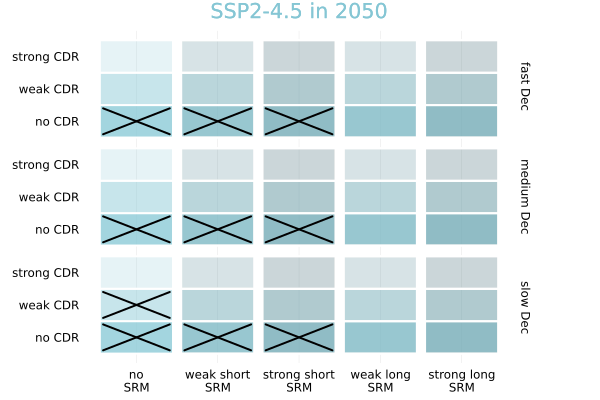

In [15]:
#---------------------------------------------------------------------
# Plotting lost options for a given scenario in a given year.
#---------------------------------------------------------------------
i_scen = 2 # SSP_scenarios = [SSP1-2.6, SSP2-4.5, SSP3-7.0, SSP5-8.5]
scen_name = ssp_names[i_scen]
i_yr = 4 # yrs_assessment[i_yr]
year = yrs_assessment[i_yr]
title = scen_name*" in "*string(year)
plot_options(FutOptions[lost_options_all[i_scen][i_yr]],title, colors[i_scen])